<a href="https://colab.research.google.com/github/fiaazwa/DeepLearning/blob/main/DaapLearning02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# === [1] Import Libraries ===
# Mengimpor pustaka yang dibutuhkan
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

In [2]:
# === [2] Mount Google Drive ===
# Mount Google Drive agar bisa akses dataset
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Dataset_DeepLearning'
import os
print(os.listdir(data_dir))

Mounted at /content/drive
['test', 'training', 'val']


In [3]:
# === [3] Data Transforms ===
# Transformasi data dan augmentasi
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
import os

print("Train exists:", os.path.exists("/content/drive/MyDrive/Dataset_DeepLearning/train"))
print("Val exists:", os.path.exists("/content/drive/MyDrive/Dataset_DeepLearning/val"))
print("Test exists:", os.path.exists("/content/drive/MyDrive/Dataset_DeepLearning/test"))


Train exists: False
Val exists: True
Test exists: True


In [5]:
# === [4] Load Dataset ===
train_data = ImageFolder(os.path.join(data_dir, 'training'), transform=transform_train)
val_data = ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_data = ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes

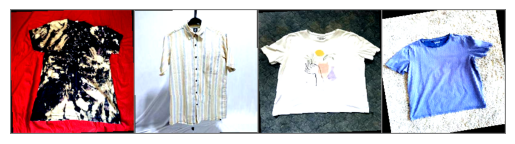

kaos kemeja kaos kaos


In [6]:
# === [5] Visualize Sample Images ===
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{class_names[labels[j]]}' for j in range(4)))

In [7]:
# === [6] Load Pretrained Model (ResNet18) ===
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [8]:
# === [7] Loss Function and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# === [8] Training Loop ===
epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")


Epoch [1/50], Train Loss: 0.7105, Val Loss: 1.0271, Val Acc: 77.22%
Epoch [2/50], Train Loss: 0.4527, Val Loss: 0.6903, Val Acc: 80.56%
Epoch [3/50], Train Loss: 0.2561, Val Loss: 0.3643, Val Acc: 85.00%
Epoch [4/50], Train Loss: 0.2174, Val Loss: 0.4845, Val Acc: 83.33%
Epoch [5/50], Train Loss: 0.2169, Val Loss: 0.6560, Val Acc: 77.78%
Epoch [6/50], Train Loss: 0.1424, Val Loss: 0.3491, Val Acc: 84.44%
Epoch [7/50], Train Loss: 0.1115, Val Loss: 0.5396, Val Acc: 86.11%
Epoch [8/50], Train Loss: 0.1283, Val Loss: 0.5343, Val Acc: 84.44%
Epoch [9/50], Train Loss: 0.1127, Val Loss: 0.3736, Val Acc: 88.33%
Epoch [10/50], Train Loss: 0.0831, Val Loss: 0.5604, Val Acc: 83.33%
Epoch [11/50], Train Loss: 0.1053, Val Loss: 0.4265, Val Acc: 88.33%
Epoch [12/50], Train Loss: 0.1245, Val Loss: 0.4072, Val Acc: 88.33%
Epoch [13/50], Train Loss: 0.1255, Val Loss: 0.3746, Val Acc: 89.44%
Epoch [14/50], Train Loss: 0.1024, Val Loss: 0.3989, Val Acc: 86.67%
Epoch [15/50], Train Loss: 0.1167, Val Loss

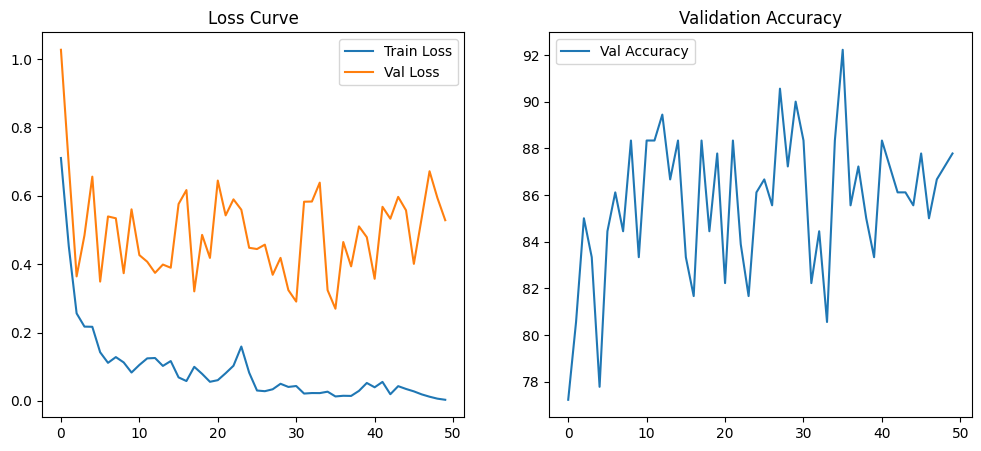

In [10]:
# === [9] Plotting Loss and Accuracy ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [22]:
# === [10] Evaluate on Test Set ===
from sklearn.metrics import accuracy_score

# Tampilkan classification report
print(classification_report(truths, preds, target_names=class_names))

# Tambahkan ini untuk menampilkan akurasi dalam bentuk angka
test_accuracy = accuracy_score(truths, preds)
print(f"Akurasi Test Set: {test_accuracy:.2f}")

              precision    recall  f1-score   support

        gaun       0.83      0.87      0.85        45
       jaket       0.96      0.98      0.97        45
        kaos       0.73      0.89      0.80        45
      kemeja       0.91      0.64      0.75        45

    accuracy                           0.84       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180

Akurasi Test Set: 0.84


In [20]:
# === [11] Predict New Image ===
import os
from PIL import Image

def predict_from_folder(folder_path, model, transform, class_names):
    model.eval()
    predictions = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                predicted_class = class_names[pred.item()]
                predictions.append((filename, predicted_class))

    return predictions

# === Jalankan Prediksi ===
predict_path = "/content/drive/MyDrive/Dataset_DeepLearning/predict"
results = predict_from_folder(predict_path, model, transform_test, class_names)

# === Tampilkan hasilnya ===
for fname, pred in results:
    print(f"{fname} => Predicted: {pred}")



img1.jpg => Predicted: jaket
img2.jpg => Predicted: gaun
img3.jpg => Predicted: kaos
img4.jpg => Predicted: jaket
img5.jpg => Predicted: kemeja
